# Spectrogram plots

Loads depth-frequency-time data and then plots spectrograms for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import numpy as np
for i in range(2):
    %matplotlib notebook

In [30]:
# import data

adcp = 'Axis75'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [31]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD
depth = ds[0].depth.values
f = ds[0].specf_s.values

## Depth-average PSD spectrograms (annual)

In [32]:
# WKB scale and depth average

WKB_u,WKB_v = [],[]
for i in range(n_seg):
    WKB_u_temp = ds[i].Sxxu_d / ds[0].WKB_scale
    WKB_v_temp = ds[i].Sxxv_d / ds[0].WKB_scale
    WKB_u.append(WKB_u_temp)
    WKB_v.append(WKB_v_temp)
    
depth_u,depth_v = [],[]
for i in range(n_seg):
    depth_u_temp = WKB_u[i].mean(dim='depth')
    depth_v_temp = WKB_v[i].mean(dim='depth')
    depth_u.append(depth_u_temp)
    depth_v.append(depth_v_temp)

In [33]:
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2

Sxxu_w,Sxxv_w = [],[]
for i in range(n_seg):
    Sxxu_white = np.copy(depth_u[i])
    for j in range(len(ds[i].spect_s)):
        Sxxu_white[:,j] = Sxxu_white[:,j]*(f**2)
    Sxxv_white = np.copy(depth_v[i])
    for j in range(len(ds[i].spect_s)):
        Sxxv_white[:,j] = Sxxv_white[:,j]*(f**2)
    Sxxu_w.append(Sxxu_white)
    Sxxv_w.append(Sxxv_white)

<IPython.core.display.Javascript object>


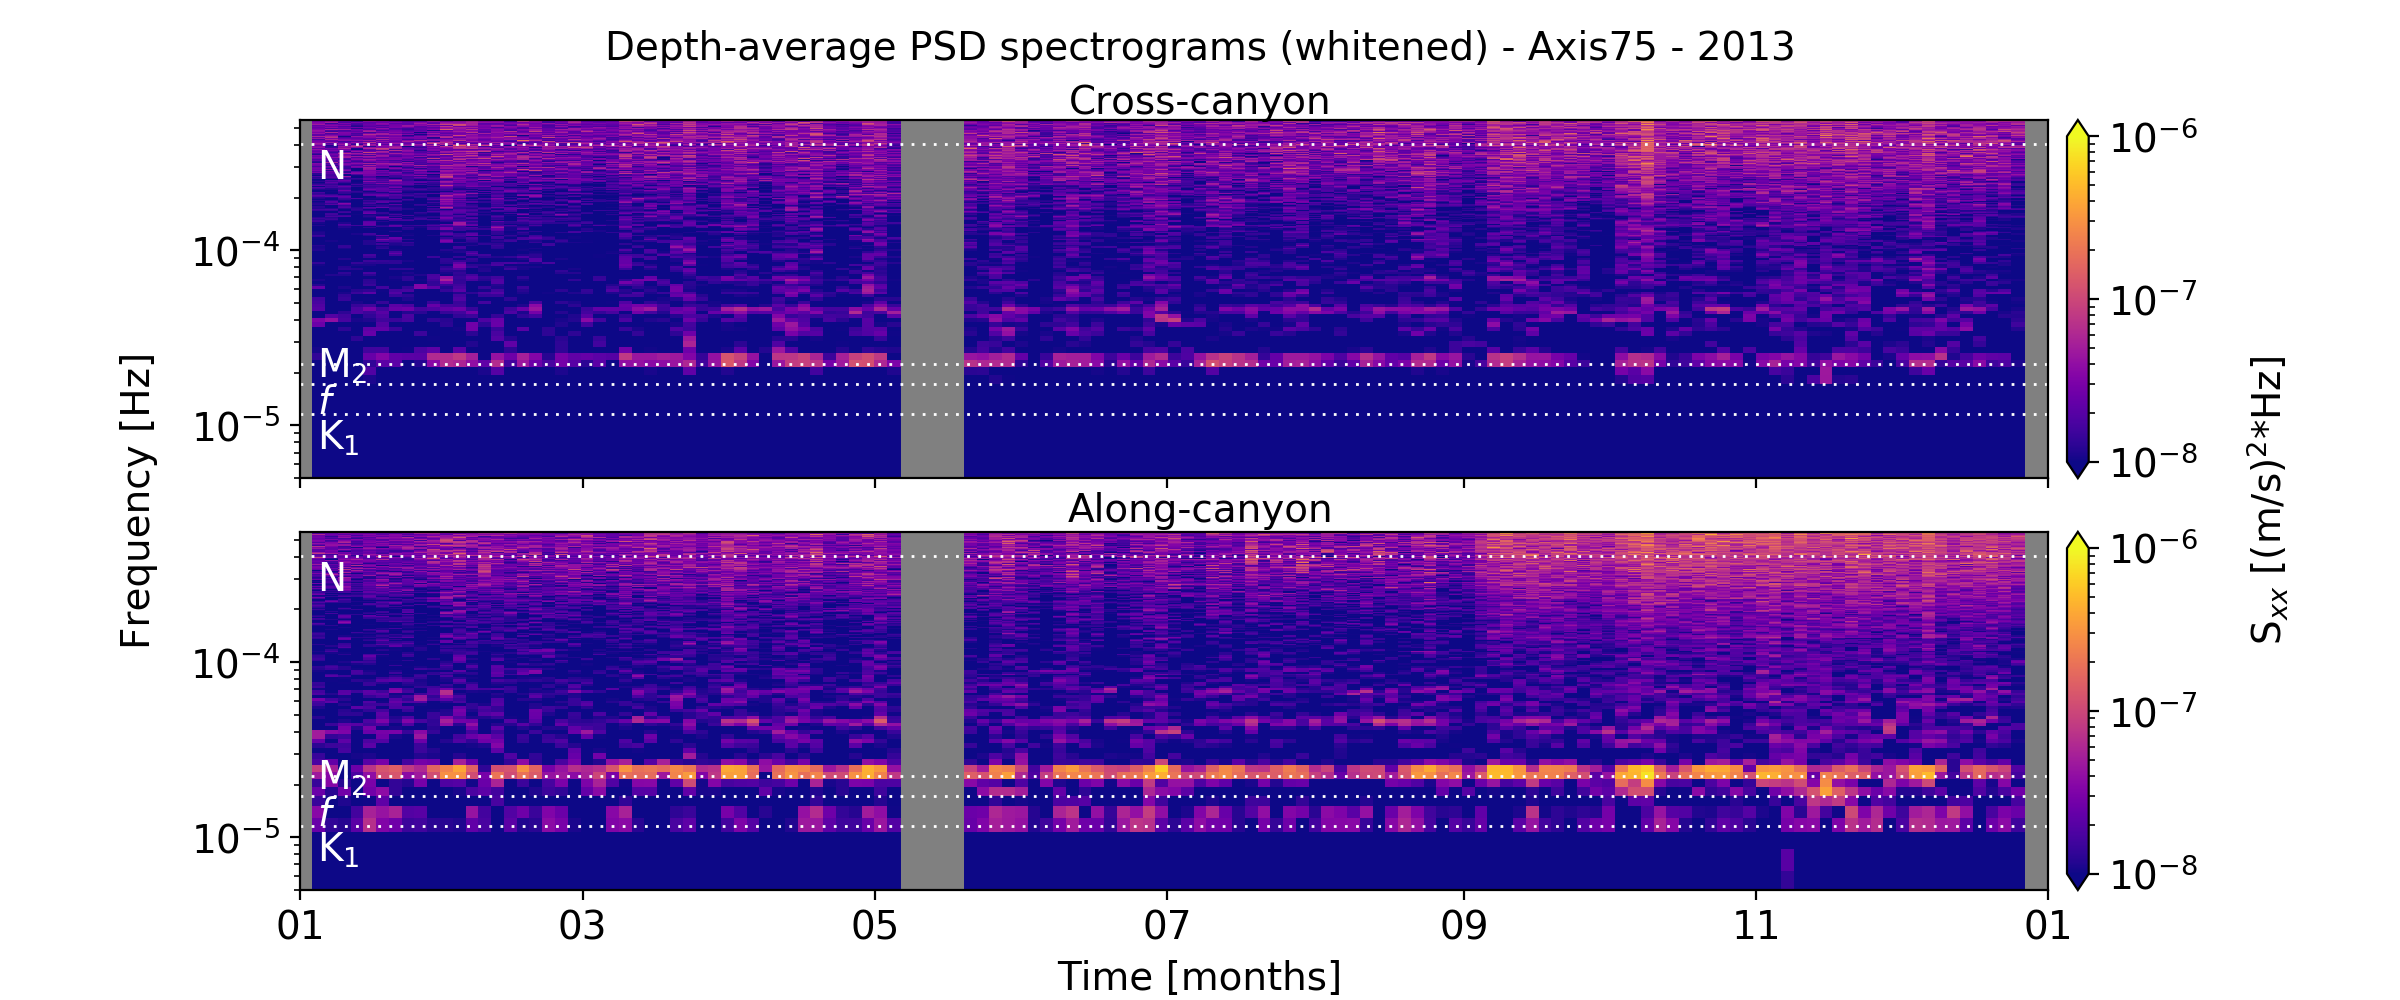

In [34]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15)
fig.text(0.5, 0.94, f'Depth-average PSD spectrograms (whitened) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.935, 0.5, 'S$_{xx}$ [(m/s)$^2$*Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.01, f'Time [months]', ha='center',fontsize=14)

if adcp == 'Slope':
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
    vmin = 1e-8
    vmax = 3e-7
elif adcp == 'Axis55' or adcp == 'Axis75':
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)
    vmin = 1e-8
    vmax = 1e-6

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, f, Sxxu_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  
    im1 = ax1.pcolormesh(ds[i].spect_s, f, Sxxv_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')    
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(5e-6,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

for i in [ax0,ax1]:
#     i.axhline(4.472e-5, color ='white',ls=(0,(1,3)),lw=1)
#     i.axhline(3.968e-5, color ='white',ls=(0,(1,3)),lw=1)
    i.axhline(2.236e-5, color ='white',ls=(0,(1,3)),lw=1)
    i.axhline(1.732e-5, color ='white',ls=(0,(1,3)),lw=1) 
    i.axhline(1.161e-5, color ='white',ls=(0,(1,3)),lw=1) 
    i.axhline(4.026e-4, color ='white',ls=(0,(1,3)),lw=1)
    i.text(0.01,0.08,'K$_1$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.18,'$f$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.28,'M$_2$',fontsize=14,color='white',transform=i.transAxes)
#     i.text(0.01,0.37,'$f$M$_2$',fontsize=14,color='white',transform=i.transAxes)
#     i.text(0.01,0.49,'M$_4$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.835,'N',fontsize=14,color='white',transform=i.transAxes)

plt.show()

plt.savefig(fname=f'./plots/spectro_plots/spectro_psd_{adcp}_{t_stamp}.pdf',format='pdf')

## Depth-average rotary spectrograms (annual)

In [35]:
# WKB scale and depth average

WKB_cw,WKB_ccw = [],[]
for i in range(n_seg):
    WKB_cw_temp = ds[i].cw_d / ds[0].WKB_scale
    WKB_ccw_temp = ds[i].ccw_d / ds[0].WKB_scale
    WKB_cw.append(WKB_cw_temp)
    WKB_ccw.append(WKB_ccw_temp)
    
depth_cw,depth_ccw = [],[]
for i in range(n_seg):
    depth_cw_temp = WKB_cw[i].mean(dim='depth')
    depth_ccw_temp = WKB_ccw[i].mean(dim='depth')
    depth_cw.append(depth_cw_temp)
    depth_ccw.append(depth_ccw_temp)

In [36]:
# 'whiten' spectrogram (flatten it) by multiplying Sxx by frequency**2

Sxxcw_w,Sxxccw_w = [],[]
for i in range(n_seg):
    Sxxcw_white = np.copy(depth_cw[i])
    for j in range(len(ds[i].spect_s)):
        Sxxcw_white[:,j] = Sxxcw_white[:,j]*(f**2)
    Sxxccw_white = np.copy(depth_ccw[i])
    for j in range(len(ds[i].spect_s)):
        Sxxccw_white[:,j] = Sxxccw_white[:,j]*(f**2)
    Sxxcw_w.append(Sxxcw_white)
    Sxxccw_w.append(Sxxccw_white)

<IPython.core.display.Javascript object>


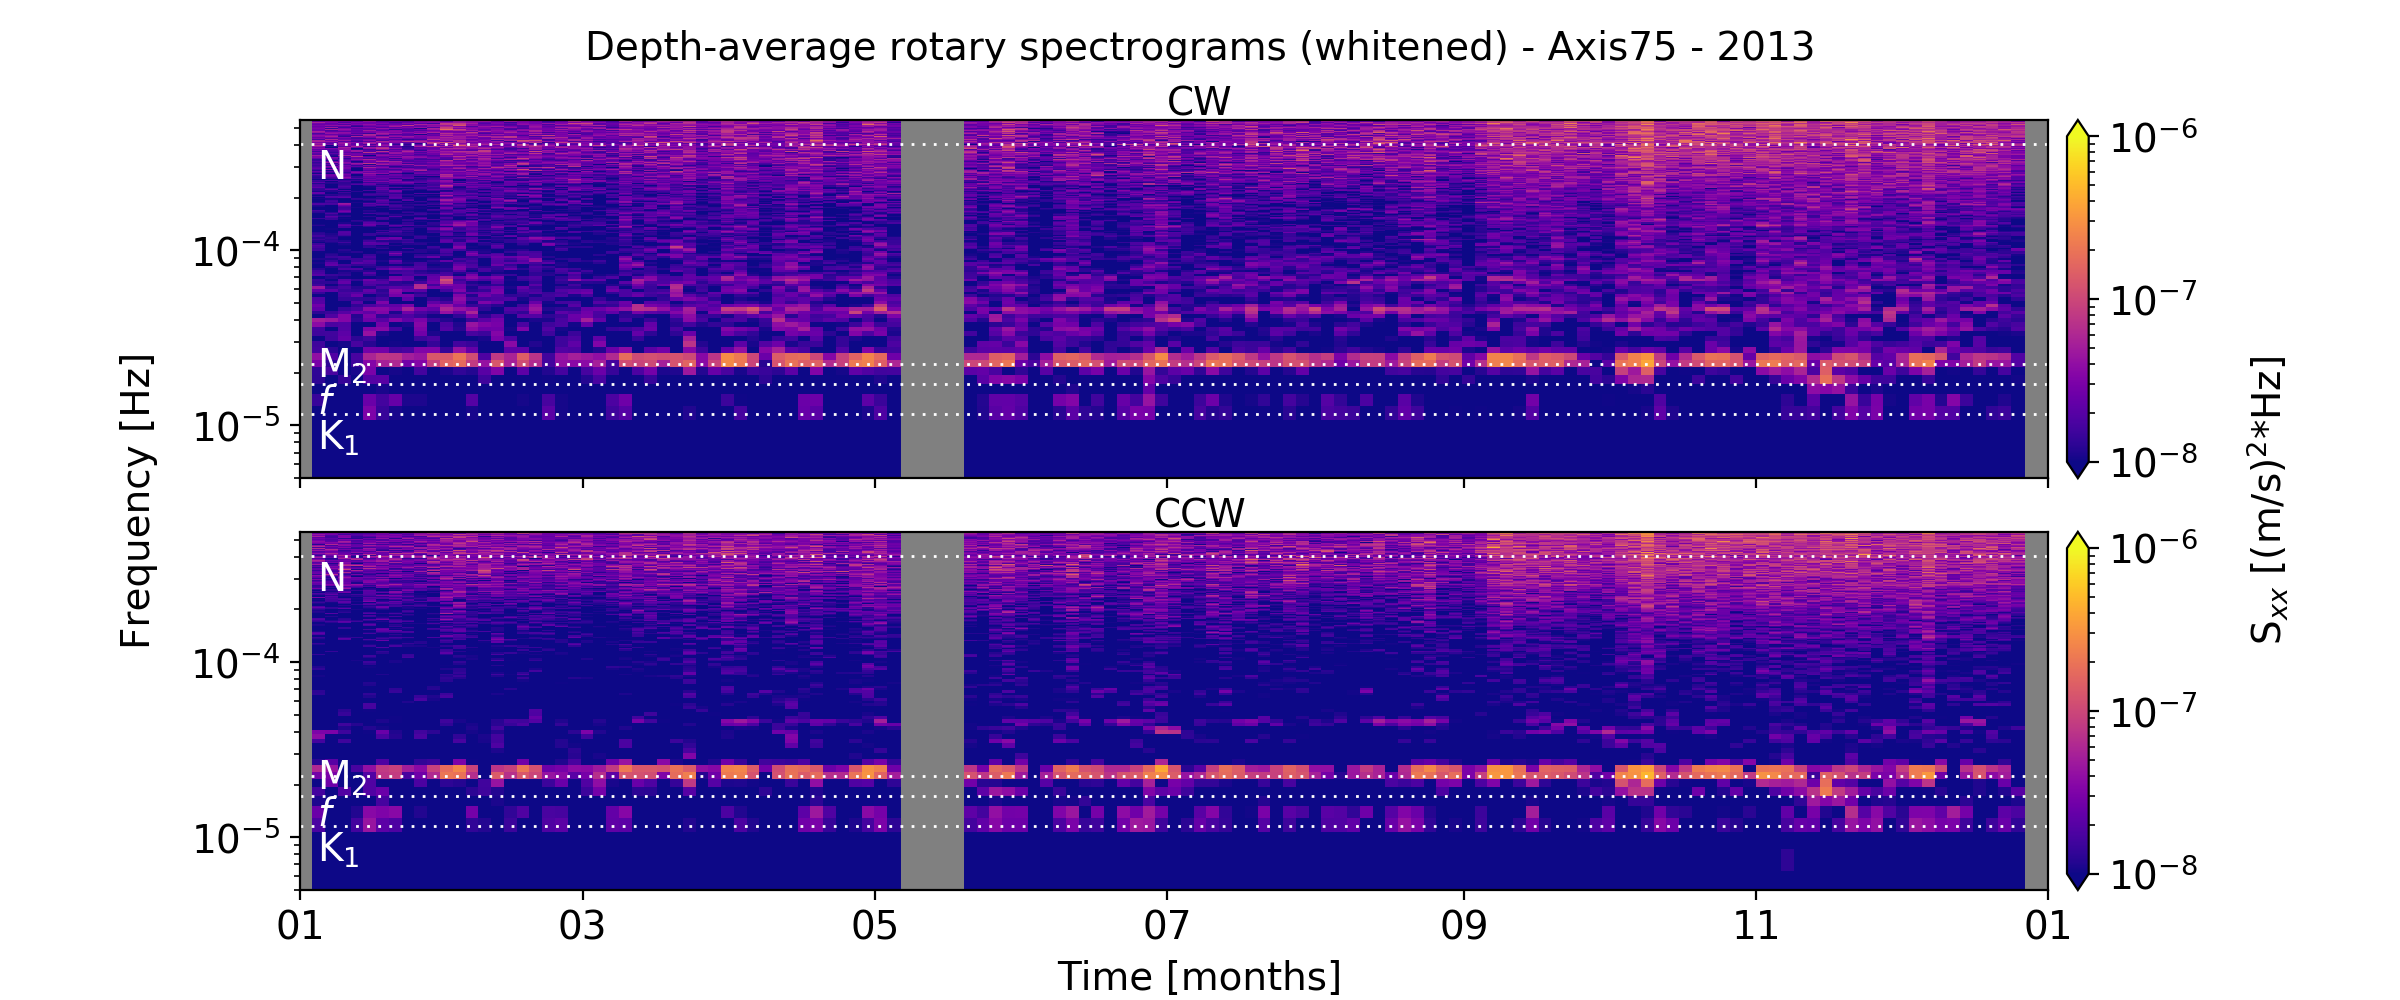

In [37]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15)
fig.text(0.5, 0.94, f'Depth-average rotary spectrograms (whitened) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.935, 0.5, 'S$_{xx}$ [(m/s)$^2$*Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.01, f'Time [months]', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = 1e-8
    vmax = 3e-7
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = 1e-8
    vmax = 1e-6

fig.text(0.5, 0.884, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.473, 'CCW', ha='center', fontsize=14) 
    
for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].spect_s, f, Sxxcw_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  
    im1 = ax1.pcolormesh(ds[i].spect_s, f, Sxxccw_w[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')    
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax0.set_yscale('log')
ax0.set_ylim(5e-6,5.55e-4)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

for i in [ax0,ax1]:
#     i.axhline(4.472e-5, color ='white',ls=(0,(1,3)),lw=1)
#     i.axhline(3.968e-5, color ='white',ls=(0,(1,3)),lw=1)
    i.axhline(2.236e-5, color ='white',ls=(0,(1,3)),lw=1)
    i.axhline(1.732e-5, color ='white',ls=(0,(1,3)),lw=1) 
    i.axhline(1.161e-5, color ='white',ls=(0,(1,3)),lw=1) 
    i.axhline(4.026e-4, color ='white',ls=(0,(1,3)),lw=1)
    i.text(0.01,0.08,'K$_1$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.18,'$f$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.28,'M$_2$',fontsize=14,color='white',transform=i.transAxes)
#     i.text(0.01,0.37,'$f$M$_2$',fontsize=14,color='white',transform=i.transAxes)
#     i.text(0.01,0.49,'M$_4$',fontsize=14,color='white',transform=i.transAxes)
    i.text(0.01,0.835,'N',fontsize=14,color='white',transform=i.transAxes)

plt.show()

plt.savefig(fname=f'./plots/spectro_plots/spectro_rot_{adcp}_{t_stamp}.pdf',format='pdf')